**Trash Image Classification using Convolutional Neural Networks**

By Dylan L. Hernandez

**Introduction:** In this project, I designed and trained a simple Convolutional Neural Network (CNN) on images of different types of trash/recyclables. The CNN I designed is loosely based of the popular VGGnet. I later use transfer learning to dramatically increase accuracy

The dataset I used is pulled from Gary Thung's trashnet repository

LINK: https://github.com/garythung/trashnet

The dataset contains a total of 2,527 images. All images are of same size (512 x 384). There are six possible classes: Cardboard, Metal, Glass, Paper, Plastic and Trash.


**Inspiration:**
When I first entered UC Berkeley as a freshman in 2016, the "Zero Waste 2020" campaign, which aimed to reduce the amount of campus waste sent to landfills, was launched. The traditional garbage cans around campus were replaced by sets of three different cans, called "Big Belly Bins", each with 3 different types of waste labels: compost, recyclables and landfill. The whole campaign relied on a "faith-based" system, where each individual would separate their trash items and place them into their respective bins. Not surprisingly, many succumbed to their laziness and didn't separate their waste. It occured to me that instead of relying on unreliable individuals to separate their waste, why not have a bin that would separate the waste itself? The **basic** idea is to have one large bin that utilizes a camera to take a snapshot of the inserted item(s) to determine the types of trash items present and automatically separate the items into their respective "sub-bins". Of course, we need a classifier that is able to analyze the image and determine the different types of items present. CNNs are perfect for this task!

LINK to Campaign website: https://zerowaste2020.universityofcalifornia.edu/



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import random

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from google.colab import drive

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
DATADIR = "/content/drive/My Drive/dataset-resized/"
CATEGORIES = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

**Data Pipeline**: 

Although all images in the dataset are of same size, I resized the images to be (150 x 150) because of limited RAM provided by Google Colab. Resizing the images will also make the training process significantly quicker. 

I split the images into training, validation and test sets (60/20/20)



*   xTrain denotes training data predictors/inputs
*   yTrain denotes training data outputs
*   xVal denotes validation data predictors/inputs
*   yVal denotes validation data outputs
*   xTest denotes test data predictors/inputs
*   yTest denotes test data outputs

NOTE: I changed the dimensions to 200x200 for transfer learning portion



In [4]:
data_array_x = []
data_array_y = []
def create_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (200, 200))
            data_array_x.append(new_array)
            data_array_y.append(class_num)
          
create_data()


Because there are multiple classes, the output labels must be one-hot encoded to suit a multi-class classifier

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(data_array_y)
encoded_Y = encoder.transform(data_array_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


In [6]:
#Example output
dummy_y[1000]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [7]:
#Split data into Train/Val/Test
from sklearn.model_selection import train_test_split
xTrain1, xTest, yTrain1, yTest = train_test_split(np.asarray(data_array_x), dummy_y, test_size = 0.2, shuffle=True, random_state = 42)

xTrain, xVal, yTrain, yVal = train_test_split(xTrain1, yTrain1, test_size = 0.2, shuffle=True, random_state = 42)

[0. 0. 0. 1. 0. 0.]


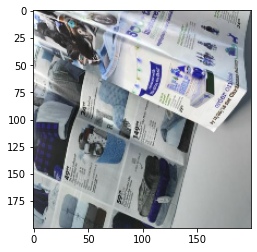

In [8]:
#TEST
plt.imshow(xVal[3])
plt.show
print(yVal[3])

**Data Preprocessing (Normalization)**

Here I use an ImageDataGenerator in order to normalize my training data (zero-centered w/ standard deviation 1). I also slightly augment my training data to add some generalization. I do this to reduce overfitting, since the dataset is relatively small.
 



In [9]:
training_generator_aug = ImageDataGenerator(rescale=1./255, rotation_range=0.2,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2)
training_generator = training_generator_aug.flow(xTrain, yTrain, batch_size=32)
validation_generator = ImageDataGenerator(rescale=1./255).flow(xVal, yVal, batch_size=32)

testing_generator = ImageDataGenerator(rescale=1./255)

In [10]:
len(yVal)

406

**Model Creation**

I used a small modified version of the popular VGG net.

I increased the number of output filters with each convolutional layer. I also used a 3x3 convolution window for each convoluitonal layer. 

I use Rectified Linear Unit (ReLU) as my activation function for each layer because it does not involve expensive operations. ReLU is also widely used in practice. 

I added pooling layers after every convolutional layer for spatial reduction. This reduces the number of trainable parameters to optimize efficiency during training

I also added a dropout layers (with 50% probability) for regularization purposes. Dropout layers are extremely effective in reducing overfitting.

My final activation function (for output layer) is softmax, since we want a probability distribution among the six possible classes.

After experimenting with different randomly generated learning rates, I ended up using 0.00019184614272688366





In [11]:
#randomized learning rate
#learning_rate = 10 ** (np.random.uniform(-6, 1, 1)[0])
learning_rate = 0.00019184614272688366

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate), loss='categorical_crossentropy', metrics=['acc'])

**Training**

In [43]:
#120 epochs
model_history = model.fit_generator(training_generator, steps_per_epoch=len(xTrain)//32, epochs=200, validation_data=validation_generator,
                            validation_steps=len(xVal)//32) 

Epoch 1/200
50/50 [==============================] - 9s 177ms/step - loss: 1.7969 - acc: 0.2106 - val_loss: 1.7579 - val_acc: 0.3802
Epoch 2/200
50/50 [==============================] - 9s 171ms/step - loss: 1.6082 - acc: 0.3174 - val_loss: 1.6996 - val_acc: 0.3262
Epoch 3/200
50/50 [==============================] - 9s 173ms/step - loss: 1.5416 - acc: 0.3796 - val_loss: 1.6515 - val_acc: 0.3503
Epoch 4/200
50/50 [==============================] - 9s 171ms/step - loss: 1.4978 - acc: 0.4016 - val_loss: 1.6977 - val_acc: 0.3824
Epoch 5/200
50/50 [==============================] - 9s 170ms/step - loss: 1.4529 - acc: 0.4199 - val_loss: 1.4363 - val_acc: 0.3824
Epoch 6/200
50/50 [==============================] - 9s 173ms/step - loss: 1.3706 - acc: 0.4312 - val_loss: 1.3927 - val_acc: 0.4813
Epoch 7/200
50/50 [==============================] - 8s 169ms/step - loss: 1.2979 - acc: 0.4733 - val_loss: 1.3418 - val_acc: 0.4545
Epoch 8/200
50/50 [==============================] - 9s 173ms/step - 

In [44]:
#Save the model
model.save('/content/drive/My Drive/TrashModel3')

**Training/Validation Summary Statistics**

Below I plot training and validation accuracy and loss during the entire training process.

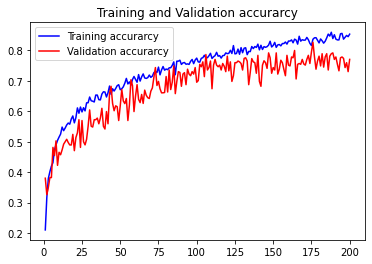

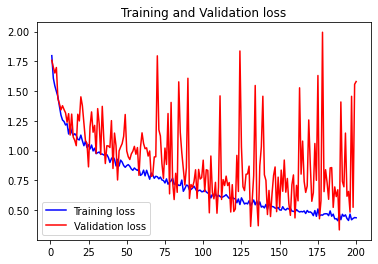

In [45]:
#Plot training and validation curves (Accuracy and Loss)
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epoch_num = range(1, len(acc) +1)

#Train and validation accuracy
plt.plot(epoch_num, acc, 'b', label='Training accurarcy')
plt.plot(epoch_num, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epoch_num, loss, 'b', label='Training loss')
plt.plot(epoch_num, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

According to the plots above, there is a small gap between the training and validation accuracy curves, which suggests that there is a small amount of overfitting. One possible solution to reduce overfitting is to add some regularization terms, such as L2 regularization, to the convolutional layers of the model.

The second plot indicates that both train and validation loss are trending downwards and the loss will likely go lower as epoch size increases. However, there is still a small gap between the two curves, which indicates a small amount of overfitting 

In [16]:
#model_loaded = keras.models.load_model('/content/drive/My Drive/TrashModel2')

**Testing Data Results**

Let's see how our model performs on a sample of 10 images from the test set!

Below are 10 images with the model predicted label along with the true label

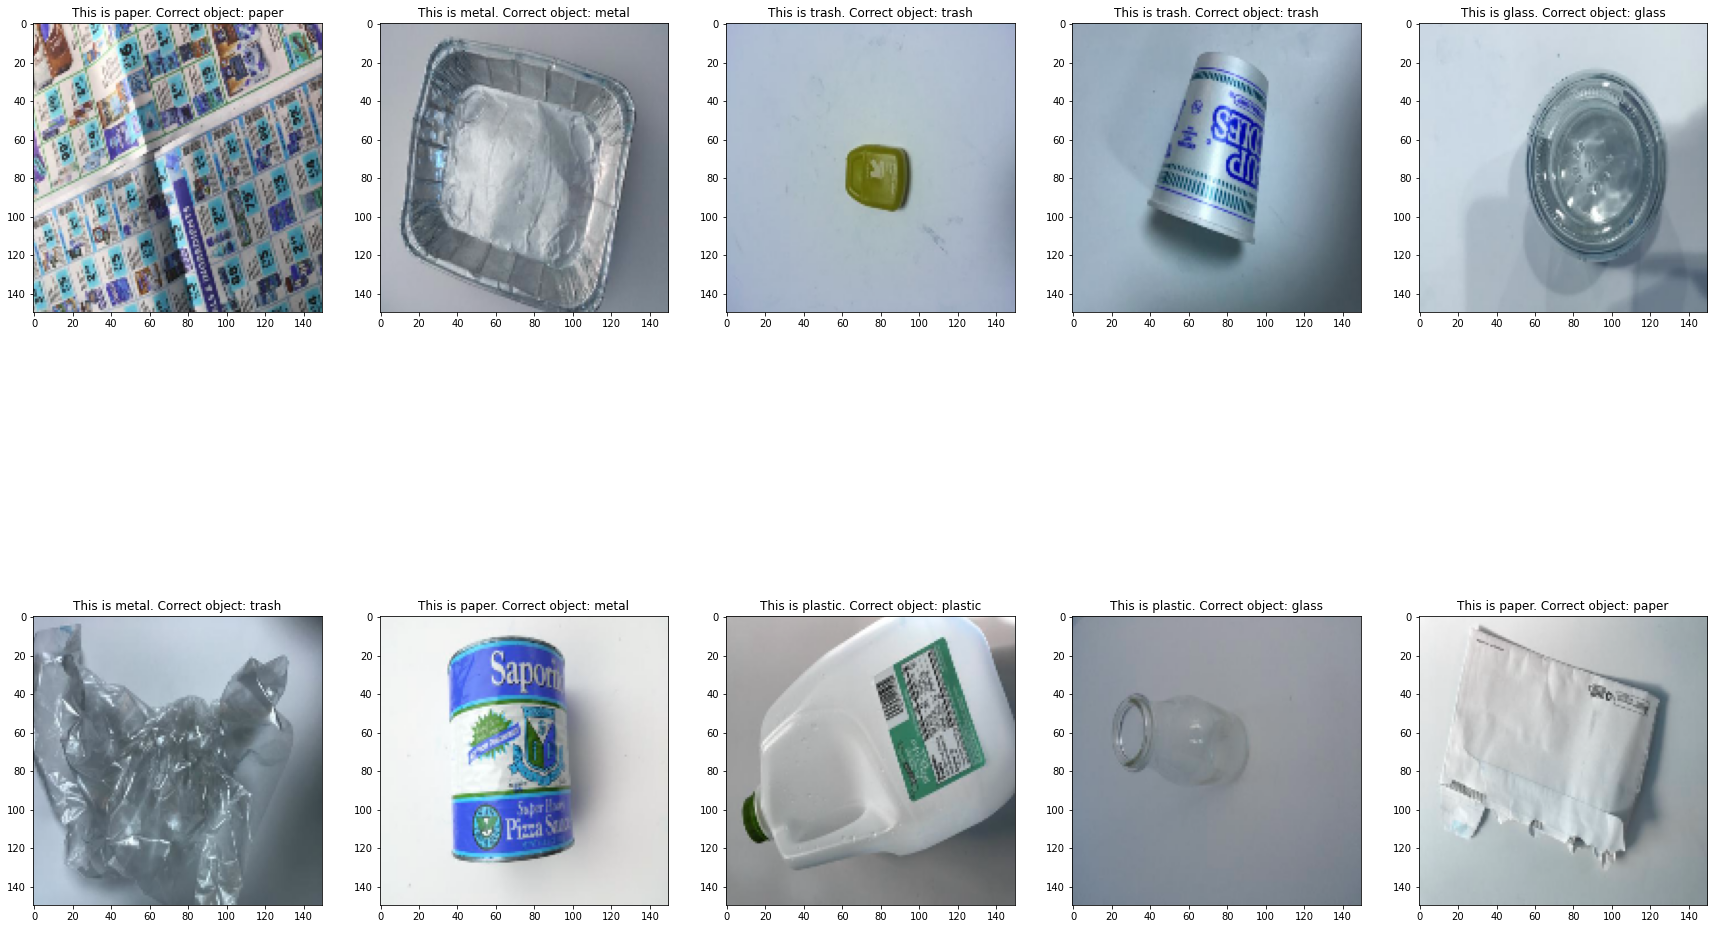

In [46]:
#Results on first five images in testing data
i = 0
text_labels = []
columns = 5
plt.figure(figsize=(30,20))
for batch in testing_generator.flow(xTest, yTest, batch_size=1):
    pred = model.predict(batch[0])
    #find index of highest (max) probability
    predicted_category = np.argmax(pred)
    text_labels.append(CATEGORIES[predicted_category])
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is ' + text_labels[i] + '. Correct object: ' + CATEGORIES[np.argmax(batch[1])])
    imgplot = plt.imshow(batch[0][0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

It appears that the model correctly classifies 7 of the 10 test samples.

It is interesting to wonder why some of the other images were misclassified. For example, the 7th image, which is a metal can, was classified as paper. However, the metal can appears to be wrapped with paper, which may have caused the model to believe it was purely a paper object. Similarly, the 6th image, which is a piece of trash, was classified as metal. However, since the trash resembles a piece of metal (gray with light reflections), the model believed it was metal. 

Perhaps adding more convolutional layers/making the model more complex (deeper) would help the model distinguish the small differences between similarly looking objects

Let's see how the model performs on the entire test set:

In [48]:
#Find total test set accuracy

i = 0
text_labels = []
total_correct = 0
#columns = 5
#plt.figure(figsize=(30,20))
for batch in testing_generator.flow(xTest, yTest, batch_size=1):
    if i == len(xTest):
      break
    pred = model.predict(batch[0])
    #find index of highest (max) probability
    predicted_category = np.argmax(pred)

    if predicted_category == np.argmax(batch[1]):
      total_correct += 1
    i += 1


accuracy_rate = total_correct/len(xTest)

print(('Test accuracy rate: ' + str(accuracy_rate)))
#plt.show()

Test accuracy rate: 0.734251968503937


It appears that the accuracy rate for our test set is around 73.43%, which is very similar to the validation accuracy above. 

For such a small dataset, the results are actually not all that bad. I can fine tune the hyperparamters and create a deeper model in order to acheive better accuracy. However, I prefer to use a method that is widely used in practice and achieves much higher accuracy rates: Transfer Learning

**Transfer learning model: InceptionResNetV2**

Because of computational costs and time, it is rare to build and train a CNN from scratch. Instead, it is common to use a pre-trained model, usually one that was trained on a very large dataset (such as ImageNet), and adapt (or "transfer") it to your own classification problem/dataset. This process, known as "transfer learning", can save a lot of time and can lead to dramatically better accuracy results. 


After experimenting with two popular models provided by the Keras library, ResNet50 and InceptionResNetV2, I decided that InceptionResNetV2 worked better on my dataset. 

Below I load InceptionResNetV2 that was trained on ImageNet, a large database with around 14 million images and around 22,000 possible categories. 

I also removed the very top layer of the imported model in order to add my own fully connected layer to classify 6 different categories. 

Below I include a summary of the number of layers and total trainable parameters in the imported model

NOTE: I changed the input size of my images to (200, 200, 3), up from previous (150,150,3)

In [11]:
#model creation
from keras.applications import InceptionResNetV2

conv_pretrained = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

conv_pretrained.summary()

219062272/219055592 [==============================] - 5s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
_____________

I started by training two models in parallel. One was simply the pre-trained model with 50% dropout and a single added fully-connected layer using softmax activation. The other was a deeper model with 4 total fully connected layers with L2 regularization 50% dropout layers following each layer. It turns out that the simple model acheived the highest accuracy and was the quickest to train. 

After experimenting with different randomly generated learning rates, I used the Adam optimizer with the default learning rate 0.0001. Adam, which is derived from Adaptive Moment Estimation, is a nice combination of both Adaptive Gradient Descent and RMSProp and is super effective!

In [12]:
modelTF = models.Sequential()
modelTF.add(conv_pretrained)

modelTF.add(layers.Flatten())
modelTF.add(layers.Dropout(0.5))
#modelTF.add(layers.Dense(256, activation='relu', kernel_regularizer='l2'))



modelTF.add(layers.Dense(6, activation='softmax'))

modelTF.compile(optimizer=optimizers.adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [13]:
#50 epochs
modelTF_history = modelTF.fit_generator(training_generator, steps_per_epoch=len(xTrain)//32, epochs=50, validation_data=validation_generator,
                            validation_steps=len(xVal)//32) 

Epoch 1/50
50/50 [==============================] - 98s 2s/step - loss: 1.4863 - acc: 0.4475 - val_loss: 1.1327 - val_acc: 0.6745
Epoch 2/50
50/50 [==============================] - 25s 508ms/step - loss: 0.6989 - acc: 0.7448 - val_loss: 0.6212 - val_acc: 0.7005
Epoch 3/50
50/50 [==============================] - 25s 505ms/step - loss: 0.4157 - acc: 0.8473 - val_loss: 0.6024 - val_acc: 0.7968
Epoch 4/50
50/50 [==============================] - 25s 503ms/step - loss: 0.2933 - acc: 0.9007 - val_loss: 0.3872 - val_acc: 0.8663
Epoch 5/50
50/50 [==============================] - 25s 505ms/step - loss: 0.2025 - acc: 0.9334 - val_loss: 0.3765 - val_acc: 0.8824
Epoch 6/50
50/50 [==============================] - 25s 505ms/step - loss: 0.1369 - acc: 0.9554 - val_loss: 0.6019 - val_acc: 0.8690
Epoch 7/50
50/50 [==============================] - 25s 503ms/step - loss: 0.1172 - acc: 0.9591 - val_loss: 0.2523 - val_acc: 0.8877
Epoch 8/50
50/50 [==============================] - 25s 505ms/step - los

In [24]:
#Save the model
modelTF.save('/content/drive/My Drive/TrashModel_ResNetTF_Final1')

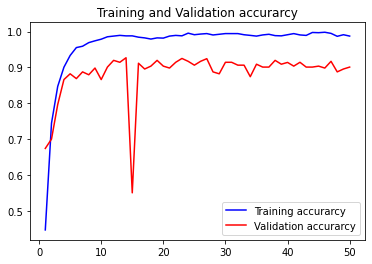

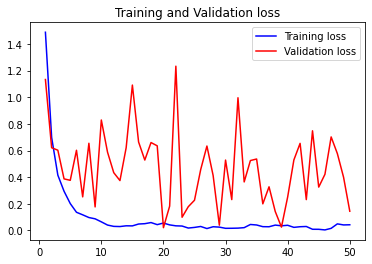

In [15]:
#Plot training and validation curves (Accuracy and Loss)
TFacc = modelTF_history.history['acc']
TFval_acc = modelTF_history.history['val_acc']
TFloss = modelTF_history.history['loss']
TFval_loss = modelTF_history.history['val_loss']

TFepoch_num = range(1, len(TFacc) +1)

#Train and validation accuracy
plt.plot(TFepoch_num, TFacc, 'b', label='Training accurarcy')
plt.plot(TFepoch_num, TFval_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(TFepoch_num, TFloss, 'b', label='Training loss')
plt.plot(TFepoch_num, TFval_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

The plots above show the training and validation loss and accuracy during the entire training process. The validation accuracy seems to settle around 90% after only ~12 epochs. The gap between validation accuracy and training accuracy indicates a small amount of overfitting. 

In [14]:
#Load the model to avoid the training process each time 
model_loaded = keras.models.load_model('/content/drive/My Drive/TrashModel_ResNetTF_Final1')

Below are the results of classifiying 10 samples from the test set

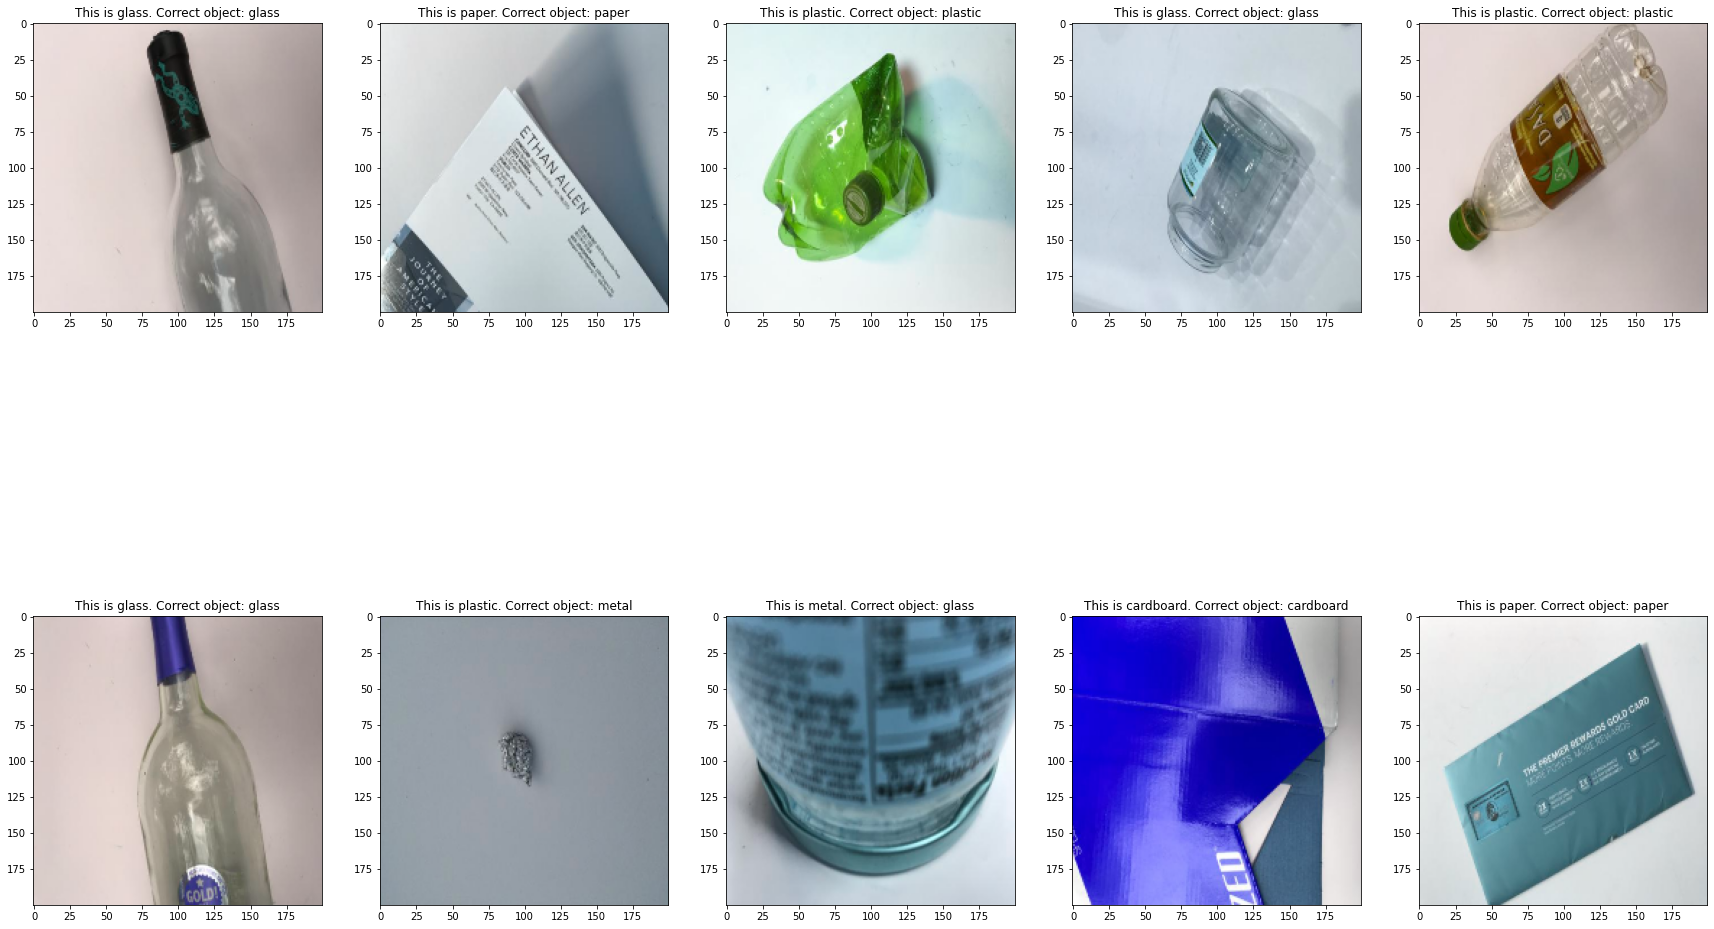

In [15]:
#Results on first five images in testing data
i2 = 0
TFtext_labels = []
TFcolumns = 5
plt.figure(figsize=(30,20))
for batch in testing_generator.flow(xTest, yTest, batch_size=1):
    pred = model_loaded.predict(batch[0])
    #find index of highest (max) probability
    predicted_category = np.argmax(pred)
    TFtext_labels.append(CATEGORIES[predicted_category])
    plt.subplot(5 / TFcolumns + 1, TFcolumns, i2 + 1)
    plt.title('This is ' + TFtext_labels[i2] + '. Correct object: ' + CATEGORIES[np.argmax(batch[1])])
    imgplot = plt.imshow(batch[0][0])
    i2 += 1
    if i2 % 10 == 0:
        break
plt.show()

This time, only 2 images were misclassified. It is interesing to note that the second misclassified object (#8) is an image of an upside down glass jar. However, it was classifed as metal likely due to the fact that the lid seems to be made of metal. 

Let's see how the model performed on the entire test set:

In [30]:
#Find total test set accuracy

i3 = 0
TFtotal_correct = 0

y_true = []
y_pred = []

for batch in testing_generator.flow(xTest, yTest, batch_size=1):
    if i3 == len(xTest):
      break
    pred = model_loaded.predict(batch[0])
    #find index of highest (max) probability
    predicted_category = np.argmax(pred)
    y_true += [CATEGORIES[np.argmax(batch[1])]]
    y_pred += [CATEGORIES[predicted_category]]

    if predicted_category == np.argmax(batch[1]):
      TFtotal_correct += 1
    i3 += 1


TFaccuracy_rate = TFtotal_correct/len(xTest)

print(('Test accuracy rate: ' + str(TFaccuracy_rate)))
#plt.show()

Test accuracy rate: 0.9094488188976378


The test set accuracy was 90.94% ! Way higher than the 73% acheived by the CNN made from "scratch". For such a small dataset, the results are not bad at all! This is the beauty of transfer learning!

Below we summarize the results using a confusion matrix:

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true, y_pred, labels=CATEGORIES)
confusion_matrix

array([[ 69,   0,   0,   4,   0,   0],
       [  0, 112,   3,   1,   0,   0],
       [  0,   8,  69,   1,   1,   1],
       [  1,   0,   1, 113,   1,   0],
       [  0,   8,   3,   2,  73,   5],
       [  0,   0,   2,   2,   2,  26]])

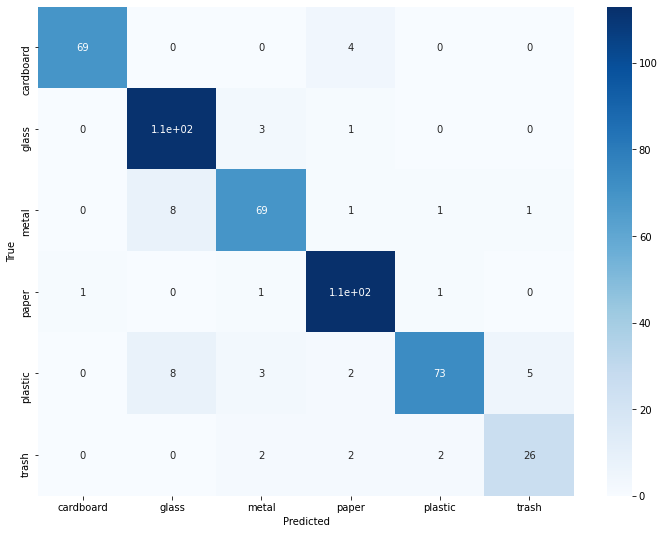

In [41]:
#Heatmap of confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in CATEGORIES],
                  columns = [i for i in CATEGORIES])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It appears that the object that is less likely to be misclassifed is cardboard, whereas the object most likely to be misclassified is glass. This makes perfect sense, since glass and plastic look pretty similar, especially in the size-reduced images

Special thanks to Rising Odegua's article "Transfer learning and Image classification using Keras on Kaggle kernels" which really helped as a guide.

Link: https://towardsdatascience.com/transfer-learning-and-image-classification-using-keras-on-kaggle-kernels-c76d3b030649
